Q-Learning for path planning and control! This algorithm will simulate a gridmap and utilize reinforcement learning to determine the best path. The path will then be traversed with PID or LQR controllers in a ROS workspace on a Turtlebot3

Credit: https://ieeexplore.ieee.org/abstract/document/6573377

In [1]:
import numpy as np
import random
from colorama import init, Fore, Back, Style
import matplotlib.pyplot as plt
import pandas as pd

Let's Generate a simulation grid map class to test the Q-learner and path planning

In [81]:
class GridGenerator:
    
    # Construct grid generator class
    def __init__(self, grid_size, num_obstacles, random):
        self.grid_size = grid_size
        self.num_obstacles = num_obstacles
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.random = random
    
    # Generate the grid
    def generate_grid(self, data):
        if self.random == True:
            # Place obstacles randomly
            obstacle_positions = random.sample(range(self.grid_size * self.grid_size), self.num_obstacles)
            for pos in obstacle_positions:
                row = pos // self.grid_size
                col = pos % self.grid_size
                self.grid[row, col] = -1  # Mark obstacle
        else: 
            # Generate grid based on given data
            obstacle_positions = data
            for pos in obstacle_positions:
                row = int(pos[0])
                col = int(pos[1])
                self.grid[row, col] = -1  # Mark obstacle
            
    # Generate the starting and stopping states
    def generate_states(self):
        states = random.sample(range(self.grid_size * self.grid_size), 2)
        for i in range(2):
            while self.grid[states[i] // self.grid_size, states[i] % self.grid_size] == -1:
                states[i] = random.choice(range(self.grid_size * self.grid_size))
        
        # Assign start and goal states to the grid
        start_row = states[0] // self.grid_size
        start_col = states[0] % self.grid_size
        self.grid[start_row, start_col] = 1
        
        target_row = states[1] // self.grid_size
        target_col = states[1] % self.grid_size
        self.grid[target_row, target_col] = 2
    
    # # Display the grid (ugly right now)
    # def print_grid(self):
    #     for row in range(self.grid_size):
    #         for col in range(self.grid_size):
    #             if self.grid[row, col] == -1:
    #                 print("██", end="")  # Print obstacle as black square
    #             elif self.grid[row, col] == 1:
    #                 print("S", end="")  # Print start as 'S'
    #             elif self.grid[row, col] == 2:
    #                 print("G", end="")  # Print goal as 'G'
    #             else:
    #                 print("  ", end=" ")  # Print empty space
    #         print()  # Move to the next line after each row



OR we can take the lidar data. Let's load it.

In [18]:
# Path to CSV file
lidar_data = 'data/pts_data.csv'

# Read the CSV file
data = pd.read_csv(lidar_data)

We need to clean the data so we aren't using hundreds of thousands of data points

In [64]:
print("Number of rows before cleaning:", len(data))

# Remove exact duplicates using Pandas
data = data.round(decimals=2)
data_cleaned = data.drop_duplicates()

# Print number of rows after cleaning
print("Number of rows after cleaning:", len(data_cleaned))

Number of rows before cleaning: 270089
Number of rows after cleaning: 24111


Now let's plot it

Data after cleaning and removing duplicates:
5757


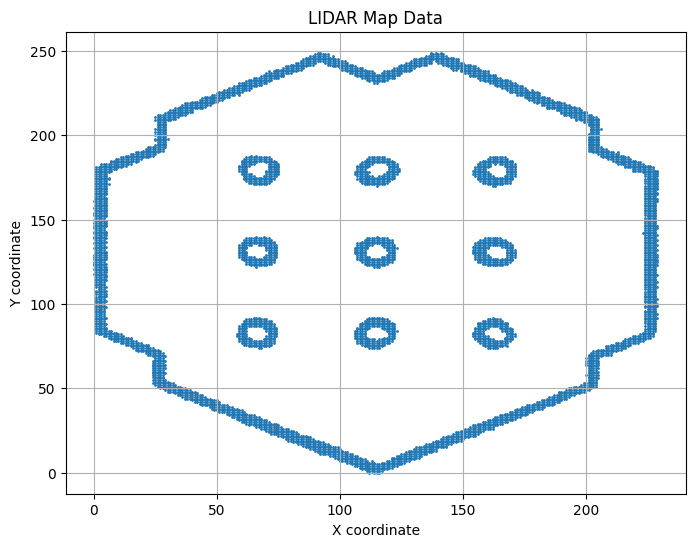

In [80]:

# Extract x and y coordinates from DataFrame
x = data_cleaned['x'].values.reshape(-1, 1)
y = data_cleaned['y'].values.reshape(-1, 1)

# Shift data to all positive for grid map indexing
x = x + np.abs(np.min(x))
y = y + np.abs(np.min(y))

# Normalize the data for creating the gridmap later
grid_size = 250 # choose grid size. Greater size means greater resolution of the obstacles
max_data = np.max([np.max(np.abs(x)),np.max(np.abs(y))])
x = np.round(x*(grid_size-1)/max_data)
y = np.round(y*(grid_size-1)/max_data)
x.astype(int)
y.astype(int)

# Concatenate x and y horizontally and remove duplicates again
data_concatenated = np.concatenate([x, y], axis=1)
data_concatenated = np.unique(data_concatenated, axis=0)
print("Data after cleaning and removing duplicates:")
print(len(data_concatenated))
x = data_concatenated[:,0]
y = data_concatenated[:,1]

# Plot the data points
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(x, y, s=1)  # s=1 sets the size of the points
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('LIDAR Map Data')
plt.grid(True)
plt.show()

Let's turn this plot into a usable gridmap

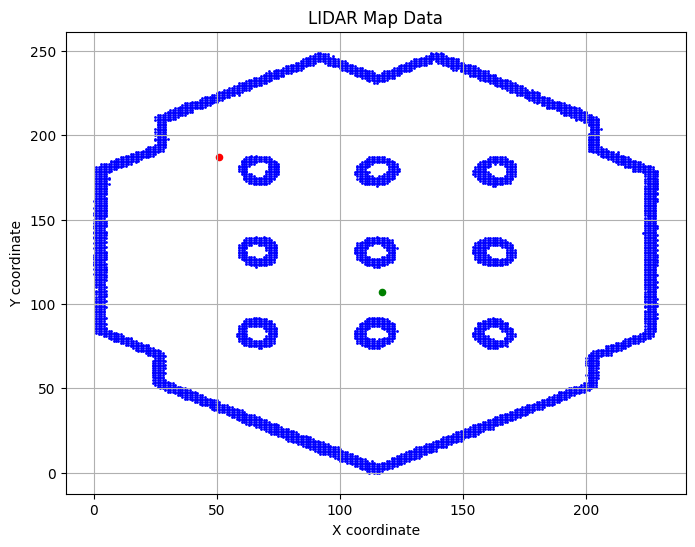

In [94]:
# Build grid object
grid_range = np.array([[np.min(x),np.max(x)], [np.min(y),np.max(y)]]) # range of grid is that of obstacles
num_obstacles = x.shape[0]

# Creating grid object and calling functions
grid_gen = GridGenerator(grid_size, num_obstacles, random = False)
grid_gen.generate_grid(data_concatenated)
grid_gen.generate_states()

## Show the created grid
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
grid_plot = np.array([])

# Separate the data into parts
grid = grid_gen.grid
grid_plot = np.array([[i, j, grid[i, j]] for i in range(grid.shape[0]) for j in range(grid.shape[1])])

obstacle_idx = grid_plot[:,2] == -1
start_idx = grid_plot[:,2] == 1
end_idx = grid_plot[:,2] == 2

obstacle_plot = grid_plot[obstacle_idx]
start_plot = grid_plot[start_idx]
end_plot = grid_plot[end_idx]

#plot the data
plt.scatter(obstacle_plot[:,0], obstacle_plot[:,1], s=1, color='blue')  # s=1 sets the size of the points
plt.scatter(start_plot[:,0], start_plot[:,1], s=20, color='red')  # s=1 sets the size of the points
plt.scatter(end_plot[:,0], end_plot[:,1], s=20, color='green')  # s=1 sets the size of the points
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('LIDAR Map Data')
plt.grid(True)
plt.show()

Build the q_learner class

In [107]:
class QLearner:
    def __init__(self, grid, start, goal, learning_rate, gamma, epsilon):
        self.grid = grid
        self.start = start
        self.goal = goal
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.state_space = grid.shape
        self.action_space = 4  # Up, down, left, right
        self.q_table = np.zeros((*self.state_space, self.action_space))
    
    # Generate rewards
    def reward(self, state):
        if state == self.goal:
            return 100  # Large reward for reaching the goal
        elif self.grid[state] == -1:
            return -100  # Large negative reward for hitting an obstacle
        else:
            return -1  # Small negative reward for each step to encourage finding the shortest path
    
    # Generate movements
    def state_observation(self, state, action):
        row, col = state
        if action == 0:  # Up
            row -= 1
        elif action == 1:  # Down
            row += 1
        elif action == 2:  # Left
            col -= 1
        elif action == 3:  # Right
            col += 1
        
        # Ensure new state is within bounds
        row = max(0, min(row, self.grid.shape[0] - 1))
        col = max(0, min(col, self.grid.shape[1] - 1))
        
        return (row, col)
    
    # Main Q-learning update rule
    def update_entry(self, state, action):
        next_state = self.state_observation(state, action) # what is the next state
        reward = self.reward(next_state) # what is the reward of that next state
        
        # Q-value update rule
        best_next_action = np.argmax(self.q_table[next_state]) # what is the best action to take at the next state? (left, right, up, down)
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        
        self.q_table[state][action] += self.learning_rate * td_error
        
        return next_state
    
    # Randomly choose to explore or exploit (random choice of direction vs look at q-table) and return the action
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.action_space - 1)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit - do action that provides best Q-value
    
    def run_q(self, episodes=1000):
        for episode in range(episodes):
            state = self.start
            while state != self.goal:
                action = self.choose_action(state) # Choose an action
                next_state = self.update_entry(state, action) # 
                state = next_state

        print("Training completed!")
        print("Q-Table:", self.q_table)
    
    # Plotting path and map
    def trace_path(self):
        state = self.start
        path = [state]
        while state != self.goal:
            action = np.argmax(self.q_table[state])
            state = self.state_observation(state, action)
            if state in path:  # Prevent infinite loops
                break
            path.append(state)
        return path

    def plot_path(self):
        path = self.trace_path()
        path_grid = self.grid.copy()
        
        for step in path:
            path_grid[step] = 3  # Mark the path
        path_grid[self.start] = 1  # Start
        path_grid[self.goal] = 2  # Goal

        plt.figure(figsize=(6, 6))
        plt.imshow(path_grid, cmap='Accent', origin='upper')
        plt.title('Q-Learner Path from Start to Goal')
        plt.show()

Now that the Q-learning is completed, we can implement it for our path planning

Training completed!
Q-Table: [[[-5.97189029 -5.98310399 -5.96605206 -5.96886774]
  [-5.9926845  -5.97451487 -5.97443125 -5.97554608]
  [-5.97747694 -5.98244339 -5.97560256 -5.97801422]
  ...
  [-7.6020748  -7.60021836 -7.60624863 -7.60172284]
  [-7.60386821 -7.60021675 -7.60242766 -7.60319662]
  [-7.59872763 -7.59961811 -7.60246525 -7.5988598 ]]

 [[-5.97634148 -5.97717672 -5.98690892 -5.97814734]
  [-5.97889768 -5.98000974 -5.97541629 -5.973583  ]
  [-5.97864159 -5.97495638 -5.9777826  -5.97607966]
  ...
  [-7.60094307 -7.60216188 -7.60204702 -7.60107995]
  [-7.60177839 -7.60083503 -7.60191692 -7.60007516]
  [-7.5985576  -7.59937303 -7.601976   -7.59874762]]

 [[-5.97516994 -5.97689755 -5.97620808 -5.97824531]
  [-5.97721805 -5.98308899 -5.9722254  -5.97405638]
  [-5.97745971 -5.97907205 -5.97432295 -5.98009353]
  ...
  [-7.60084844 -7.6030378  -7.6021156  -7.60118432]
  [-7.60102994 -7.59967252 -7.60004949 -7.60125602]
  [-7.5999144  -7.59914537 -7.60088935 -7.60075334]]

 ...

 [[-5

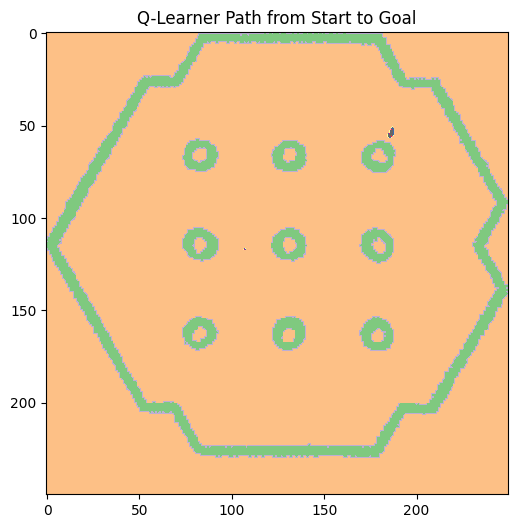

Blue = Start, Red = Goal


In [110]:
# Generate the grid
# grid_gen = GridGenerator(30, 200)
# grid_gen.generate_grid()
# grid_gen.generate_states()

# grid_gen.print_grid()

start = tuple(np.argwhere(grid_gen.grid == 1)[0])
goal = tuple(np.argwhere(grid_gen.grid == 2)[0])

# Train Q-Learner
q_learner = QLearner(grid_gen.grid, start, goal, learning_rate=0.01, gamma=0.9, epsilon=0.5)
q_learner.run_q(episodes=10000)

# Plot the path
q_learner.plot_path()
print('Blue = Start, Red = Goal')
